# The reach of Logic Tensor Networks

**Premise:** we suggest going through the tutorials (`/tutorial` folder) before going through these examples.

The objective of this series of examples is to show how the language of Real Logic can be used to specify a number of
tasks that involve learning from data and reasoning. Examples of such tasks are classification, regression, clustering,
link prediction, etc.

The solution of a problem specified in Real Logic is obtained by interpreting such a specification in Logic Tensor Networks.
The LTN library implements Real Logic in PyTorch. Every logical operator is grounded using PyTorch primitives such that
LTN implements directly a PyTorch graph. Due to PyTorch built-in optimization, LTN is relatively efficient while
providing the expressive power of first-order logic.

The first tutorial that we will see is based on one of the most simple and intuitive machine learning tasks, the binary
classification.

## Binary classification

The simplest machine learning task is binary classification. Suppose that one wants to learn a binary classifier $A$ for
a set of points in $[0, 1]^2$. Suppose that a set of positive and negative training examples is given.

LTN uses the following language and grounding:

**Domains:**
- $points$ (denoting the examples);

**Variables:**
- $x_+$ for the positive examples;
- $x_-$ for the negative examples;
- $x$ for all examples;
- $D(x) = D(x_+) = D(x_-) = points$, where $D(.)$ is a function which returns the domain of a non-logical symbol given in
input.

**Predicates:**
- $A(x)$ for the trainable classifier;
- $D_{in}(A) = points$, where $D_{in}(.)$ is a function which returns the domain of the input of a function or predicate
given in input.

**Axioms:**

- $\forall x_+ A(x_+)$: the predicate must be true for positive examples;
- $\forall x_- \lnot A(x_-)$: the predicate must be false for negative examples.

**Grounding:**
- $\mathcal{G}(points)=[0,1]^{2}$;
- $\mathcal{G}(x) \in[0,1]^{m \times 2}$: $\mathcal{G}(x)$ is a sequence of $m$ points, that is, $m$ examples;
- $\mathcal{G}\left(x_{+}\right)=\langle d \in \mathcal{G}(x) \mid\|d-(0.5,0.5)\|<0.09\rangle$: $\mathcal{G}(x_+)$ are,
by definition in this example, the training examples with Euclidean distance to the center $(0.5, 0.5)$ smaller than
the threshold of 0.09;
- $\mathcal{G}\left(x_{+}\right)=\langle d \in \mathcal{G}(x) \mid\|d-(0.5,0.5)\|>=0.09\rangle$: $\mathcal{G}(x_+)$ are,
by definition in this example, the training examples with Euclidean distance to the center $(0.5, 0.5)$ larger or equal
to the threshold of 0.09;
- $\mathcal{G}(A \mid \theta): x \mapsto \sigma\left(\operatorname{MLP}_{\theta}(x)\right)$, where $MLP$
is a Multi-Layer Perceptron with a single output neuron, whose parameters $\theta$ have to be learned.


### Dataset

Now, let's define our toy dataset with points in $[0, 1]^2$. We randomly generate 100 points, and we give them some labels
according to the *grounding* defined above. So, points near the center will be classified as positives, while points distant
from the center will be classified as negatives.

In [9]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Set display options
pd.set_option('display.max_columns', None)

# Load the Ethereum Fraud Detection Dataset
data = pd.read_csv("transaction_dataset.csv")

# Data preprocessing and feature engineering (handle missing data, encode categorical variables, etc.)
data.drop(columns=["Index", "Address", "Unnamed: 0", " ERC20 most sent token type", " ERC20_most_rec_token_type", " ERC20 uniq rec token name", " ERC20 uniq sent token name", "min value sent to contract", " ERC20 uniq sent addr.1"], axis=1, inplace=True)

# Features (assuming all other columns are features)
features = data.drop(columns=['FLAG'])

# Identify and handle NaN values
columns_with_nan = features.columns[features.isna().any()].tolist()

# Choose a strategy to handle NaN values (e.g., replace with 0 or drop rows)
# Here, we'll replace NaN values with 0, but you can modify this as needed.
features.fillna(0, inplace=True)

# Convert the remaining dataset to a tensor of type float32
dataset = torch.tensor(features.values, dtype=torch.float32)
print(torch.isnan(dataset).any())  # Check if there are any NaN values in the dataset

labels_dataset = torch.tensor(data['FLAG'].values, dtype=torch.float32)


tensor(False)


Let's plot our dataset and see that points around the center have a positive label, while points far from the center have
negative labels.

Nombre de points A: 2179
Nombre de points ~A: 7662


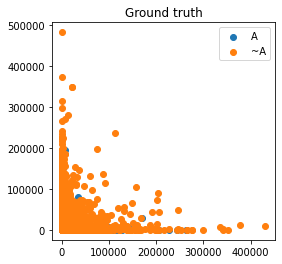

In [10]:
# Convertissez les labels_dataset en un tenseur booléen si ce n'est pas déjà le cas
labels_dataset = labels_dataset.bool()

# Comptez le nombre de chaque classe
count_A = labels_dataset.sum().item()
count_not_A = (~labels_dataset).sum().item()

print('Nombre de points A:', count_A)
print('Nombre de points ~A:', count_not_A)

plt.figure(figsize=(4,4))
plt.scatter(dataset[labels_dataset][:,0],dataset[labels_dataset][:,1],label='A')
plt.scatter(dataset[torch.logical_not(labels_dataset)][:,0],dataset[torch.logical_not(labels_dataset)][:,1],label='~A')
plt.title("Ground truth")
plt.legend()
plt.show()

### LTN setting

In order to define our knowledge base (axioms), we need to define predicate $A$, the connectives, quantifiers, and the
`SatAgg` operator.

For the connective and quantifiers, we use the stable product configuration (seen in the tutorials). For predicate $A$, we use a simple $MLP$
implemented as a `torch.nn.Module`.

`SatAgg` is the SAT aggregator, an operator which aggregates the truth values of all the closed
formulas included in the knowledge base. The `SatAgg`, by default, is implemented using the `pMeanError` aggregator.

In [11]:
import ltn
# we define predicate A
class ModelA(torch.nn.Module):
    def __init__(self):
        super(ModelA, self).__init__()
        self.sigmoid = torch.nn.Sigmoid()
        self.layer1 = torch.nn.Linear(41, 32) # 41 features
        self.layer2 = torch.nn.Linear(32, 16)
        self.layer3 = torch.nn.Linear(16, 1)
        self.elu = torch.nn.ELU()

    def forward(self, x):
        x = self.elu(self.layer1(x))
        x = self.elu(self.layer2(x))
        x = self.layer3(x)
        x = self.sigmoid(x)  # Assure que la sortie est dans [0, 1]
        print("x:", x)
        return x

A = ltn.Predicate(ModelA())

# we define the connectives, quantifiers, and the SatAgg
Not = ltn.Connective(ltn.fuzzy_ops.NotStandard())
Forall = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=2), quantifier="f")
SatAgg = ltn.fuzzy_ops.SatAgg()

### Utils

Now, we need to define some utility classes and functions.

We define a standard PyTorch data loader, which takes as input the dataset and returns a generator of batches of data.
In particular, we need a data loader instance for training data and one for testing data. 50 examples are selected
for training, 50 examples are selected for testing.

Then, we define functions to evaluate the model performances. The model is evaluated on the test set using the following metrics:
- the satisfaction level of the knowledge base: measure the ability of LTN to satisfy the knowledge;
- the classification accuracy: measure the quality of the predictions.

In [12]:
from sklearn.metrics import accuracy_score
import numpy as np

# this is a standard PyTorch DataLoader to load the dataset for the training and testing of the model
class DataLoader(object):
    def __init__(self,
                 data,
                 labels,
                 batch_size=1,
                 shuffle=True):
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle

    def __len__(self):
        return int(np.ceil(self.data.shape[0] / self.batch_size))

    def __iter__(self):
        n = self.data.shape[0]
        idxlist = list(range(n))
        if self.shuffle:
            np.random.shuffle(idxlist)

        for _, start_idx in enumerate(range(0, n, self.batch_size)):
            end_idx = min(start_idx + self.batch_size, n)
            data = self.data[idxlist[start_idx:end_idx]]
            labels = self.labels[idxlist[start_idx:end_idx]]

            yield data, labels


# define metrics for evaluation of the model

# it computes the overall satisfaction level on the knowledge base using the given data loader (train or test)
def compute_sat_level(loader):
    mean_sat = 0
    for data, labels in loader:
        x_A = ltn.Variable("x_A", data[torch.nonzero(labels)])  # positive examples
        x_not_A = ltn.Variable("x_not_A",
                               data[torch.nonzero(torch.logical_not(labels))])  # negative examples
        mean_sat += SatAgg(
            Forall(x_A, A(x_A)),
            Forall(x_not_A, Not(A(x_not_A)))
        )
    mean_sat /= len(loader)
    return mean_sat

# it computes the overall accuracy of the predictions of the trained model using the given data loader
# (train or test)
def compute_accuracy(loader):
    mean_accuracy = 0.0
    for data, labels in loader:
        predictions = A.model(data).detach().numpy()
        predictions = np.where(predictions > 0.5, 1., 0.).flatten()
        mean_accuracy += accuracy_score(labels, predictions)

    return mean_accuracy / len(loader)

# create train and test loader, 50 points each
# batch size is 64, meaning there is only one batch for epoch
# train_loader = DataLoader(dataset[:50], labels_dataset[:50], 64, True)
# test_loader = DataLoader(dataset[50:], labels_dataset[50:], 64, False)

# Supposons que vous voulez utiliser 80% des données pour l'entraînement
split_idx = int(0.8 * len(dataset))
batch_size = 64  # Réduisez la taille du batch si nécessaire

train_loader = DataLoader(dataset[:split_idx], labels_dataset[:split_idx], batch_size, True)
test_loader = DataLoader(dataset[split_idx:], labels_dataset[split_idx:], batch_size, False)

### Learning
Let us define $D$ the data set of all examples. The objective function with $\mathcal{K}=\left\{\forall x_{+} A\left(x_{+}\right), \forall x_{-} \neg A\left(x_{-}\right)\right\}$
is given by $\operatorname{SatAgg}_{\phi \in \mathcal{K}} \mathcal{G}_{\boldsymbol{\theta}, x \leftarrow \boldsymbol{D}}(\phi)$.

In practice, the optimizer uses the following loss function:

$\boldsymbol{L}=\left(1-\underset{\phi \in \mathcal{K}}{\operatorname{SatAgg}} \mathcal{G}_{\boldsymbol{\theta}, x \leftarrow \boldsymbol{B}}(\phi)\right)$

where $B$ is a mini batch sampled from $D$.

The notation $\mathcal{G}_{x \leftarrow \boldsymbol{D}}(\phi(x))$ means that the variable $x$ is grounded with the data $D$ when
grounding $\phi(x)$.

By minimizing the loss, we will try to maximize the `SatAgg` operator applied to the knowledge base. Maximizing the `SatAgg` operator
means maximizing the satisfaction level of each formula included in the knowledge base.

Notice that the objective and the loss function depend on the following hyper-parameters:
- the choice of fuzzy logic operator semantics used to approximate each connective and quantifier;
- the choice of hyper-parameters underlying the operators, such as the value of the exponent $p$ in any generalized mean;
- the choice of formula aggregator function `SatAgg`.

In the following, we learn our LTN in the binary classification task using the satisfaction of the knowledge base as
an objective. In other words, we want to learn the parameters $\theta$ of unary predicate $A$ in such a way the two
axioms in the knowledge base are maximally satisfied. We train our model for 1000 epochs and use the `Adam` optimizer.

The following figure shows the LTN computational graph for this specific task.

![Computational graph](/examples/images/binary-classification.png)

In [13]:
optimizer = torch.optim.Adam(A.parameters(), lr=0.001)

# training of the predicate A using a loss containing the satisfaction level of the knowledge base
# the objective it to maximize the satisfaction level of the knowledge base
for epoch in range(1000):
    train_loss = 0.0
    for batch_idx, (data, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        # print("data shape:", data.shape)
        # print("labels shape:", labels.shape)

        # we ground the variables with current batch data
        # x_A = ltn.Variable("x_A", data[torch.nonzero(labels)]) # positive examples
        # x_not_A = ltn.Variable("x_not_A", data[torch.nonzero(torch.logical_not(labels))]) # negative examples

        # Obtenir les indices des exemples positifs et négatifs
        indices_pos = torch.nonzero(labels, as_tuple=True)
        indices_neg = torch.nonzero(torch.logical_not(labels), as_tuple=True)

        # Utiliser ces indices pour indexer `data` directement, sans ajouter de dimension supplémentaire
        x_A = ltn.Variable("x_A", data[indices_pos])  # Exemples positifs
        x_not_A = ltn.Variable("x_not_A", data[indices_neg])  # Exemples négatifs

        # Assurez-vous que les variables ne sont pas vides avant de procéder
        if x_A.value.numel() > 0 and x_not_A.value.numel() > 0:
            # Calculer la satisfaction moyenne sur le batch
            sat_agg = SatAgg(
                Forall(x_A, A(x_A)),
                Forall(x_not_A, Not(A(x_not_A)))
            )
            loss = 1. - sat_agg
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            print("epoch %d | batch %d | loss %.4f" % (epoch, batch_idx, loss.item()))
        else:
            # Traitez le batch vide différemment ou ignorez-le
            print("epoch %d | batch %d | Empty batch, skipping" % (epoch, batch_idx))
            continue
    train_loss = train_loss / len(train_loader)

    # we print metrics every 20 epochs of training
    if epoch % 20 == 0:
        print(" epoch %d | loss %.4f | Train Sat %.3f | Test Sat %.3f | Train Acc %.3f | Test Acc %.3f"
              %(epoch, train_loss, compute_sat_level(train_loader), compute_sat_level(test_loader),
                    compute_accuracy(train_loader), compute_accuracy(test_loader)))

x: tensor([[0.]], grad_fn=<SigmoidBackward0>)
x: tensor([[0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [7.3331e-01],
        [2.4847e-01],
        [0.0000e+00],
        [0.0000e+00],
        [2.5839e-06],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [1.3167e-06],
        [0.0000e+00],
        [0.0000e+00],
        [3.8398e-05],
        [2.1054e-04],
        [5.0119e-05],
        [0.0000e+00],
        [0.0000e+00],
        [3.6858e-05],
        [1.5155e-01],
        [4.7253e-01],
        [0.0000e+00],
        [3.8493e-05],
        [0.0000e+00],
        [2.8717e-02],
        [8.5450e-05],
        [0.0000e+00],
        [0.0000e+00],
        [2.6336e-04],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [3.1930e-05],
     

epoch 0 | batch 32 | loss 0.3247
x: tensor([[0.]], grad_fn=<SigmoidBackward0>)
x: tensor([[0.0000e+00],
        [2.2096e-34],
        [0.0000e+00],
        [5.2777e-37],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [8.3781e-12],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [9.6083e-12],
        [0.0000e+00],
        [0.0000e+00],
        [1.8794e-04],
        [0.0000e+00],
        [1.0471e-11],
        [3.8937e-10],
        [0.0000e+00],
        [0.0000e+00],
        [5.0662e-02],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [2.8685e-04],
        [8.9091e-04],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [2.2451e

ValueError: Expected inputs of connectives and quantifiers to be tensors of truth values in the range [0., 1.], but got some values outside this range.

Notice that variables $x_+$ and $x_-$ are grounded batch by batch with new data arriving from the data loader. This is exactly what
we mean with $\mathcal{G}_{x \leftarrow \boldsymbol{B}}(\phi(x))$, where $B$ is a mini-batch sampled by the data loader.

Notice also that `SatAgg` takes as input the two axioms and returns one truth value which can be interpreted as the satisfaction
level of the knowledge base.

Note that after 800 epochs the test accuracy is around 1. This shows the power of LTN in learning
the binary classification task only using the satisfaction of a knowledge base as an objective.

In the following, we query predicate $A$ on training data and test data. The plot shows the extent of generalization.

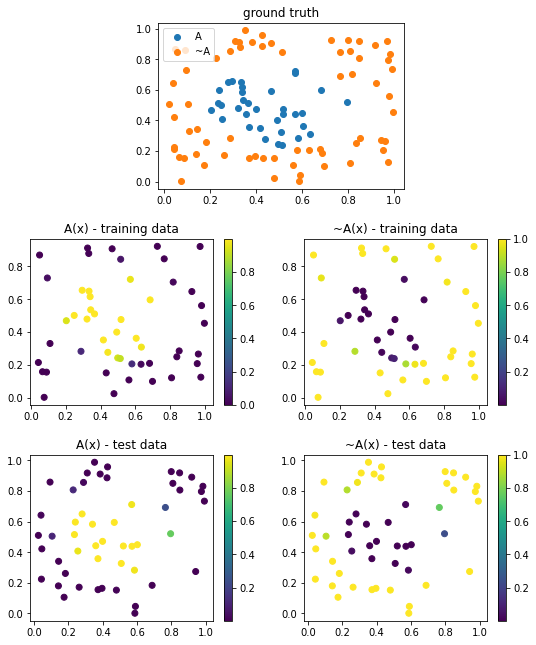

In [ ]:
nr_samples_train = 50

fig = plt.figure(figsize=(9, 11))

plt.subplots_adjust(wspace=0.2,hspace=0.3)
ax = plt.subplot2grid((3,8),(0,2),colspan=4)
ax.set_title("ground truth")
ax.scatter(dataset[labels_dataset][:,0],dataset[labels_dataset][:,1],label='A')
ax.scatter(dataset[torch.logical_not(labels_dataset)][:,0],dataset[torch.logical_not(labels_dataset)][:,1],label='~A')
ax.legend()

# Training data
x = ltn.Variable("x",dataset[:nr_samples_train])
fig.add_subplot(3, 2, 3)
result=A(x)
plt.title("A(x) - training data")
plt.scatter(dataset[:nr_samples_train,0],dataset[:nr_samples_train,1],c=result.value.detach().numpy().squeeze())
plt.colorbar()

fig.add_subplot(3, 2, 4)
result=Not(A(x))
plt.title("~A(x) - training data")
plt.scatter(dataset[:nr_samples_train,0],dataset[:nr_samples_train,1],c=result.value.detach().numpy().squeeze())
plt.colorbar()

# Test data
x = ltn.Variable("x",dataset[nr_samples_train:])
fig.add_subplot(3, 2, 5)

result=A(x)
plt.title("A(x) - test data")
plt.scatter(dataset[nr_samples_train:,0],dataset[nr_samples_train:,1],c=result.value.detach().numpy().squeeze())
plt.colorbar()

fig.add_subplot(3, 2, 6)
result=Not(A(x))
plt.title("~A(x) - test data")
plt.scatter(dataset[nr_samples_train:,0],dataset[nr_samples_train:,1],c=result.value.detach().numpy().squeeze())
plt.colorbar()
plt.savefig("ex_binary_testing.pdf")
plt.show()

### Discussion

This first example, although straightforward, illustrates step-by-step the process of using LTN on a simple setting.

In particular, the knowledge has been used only to give the ground truth to the model. Through the knowledge, the model
knows that predicate $A$ has to be maximized when the input is a positive example, while it has to be minimized when the
input is a negative example. This is exactly what the binary cross-entropy does. So, using LTN we have reached the same
result with just a different setting.

In general, methods such LTN work well when the knowledge codifies new information respect to the ground truth. In other
words, when information that come from data and knowledge is complementary, namely it is not redundant.

In the next tutorials, we will show how the LTN language can be used to solve progressively more complex
problems by combining learning and reasoning.